In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from joblib import load
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# Analysis on Best Model
- Scaler: RobustScaler
- Feature Set: Feats#2
- Algorithm: XGBRegressor

## Helper Functions to Add Predicted Close Price to Test Data

In [2]:
# def train_test_split(df):
#     train_len = int(len(df)*.8)
#     train_dataset = df[:train_len]
#     test_dataset = df[train_len:len(df)]

#     train_features = train_dataset.copy()
#     test_features = test_dataset.copy()

#     train_labels = train_features.pop('Close')
#     test_labels = test_features.pop('Close')
#     return train_features, test_features, train_labels, test_labels

In [3]:
# def predict_fn(company, test_features, df, train_len=1967):
#     """
#     Helper function to predict test features
#     """
#     model = xgb.XGBRegressor()
#     model.load_model(f'./experiments_robust/XGBReg/models/{company}.json')
    
#     close_scaler = load(f'./experiments_robust/feature_engineering/{company}_close_scaler.bin')
    
#     features_scaler = load(f'./experiments_robust/feature_engineering/{company}_features_scaler.bin')
    
#     pred = model.predict(test_features)

#     actual_close = df[['Close']]
#     actual_close = pd.DataFrame(actual_close.iloc[train_len:, 0])

#     pred = pd.DataFrame(pred)
#     pred.reset_index(drop=True, inplace=True)
#     pred.index = test_features.index
#     pred['Actual'] = actual_close['Close']
#     pred.rename(columns={0:'Pred'}, inplace=True)
    
#     features = test_features.columns
#     test_features[features] = features_scaler.inverse_transform(test_features[features])
    
#     test_features['Predicted Close'] = pred['Pred']
#     test_features['Actual Close'] = pred['Actual']
    
#     test_features['Predicted Close'] = close_scaler.inverse_transform(
#         np.array(test_features['Predicted Close']).reshape(-1,1))
#     test_features['Actual Close'] = close_scaler.inverse_transform(
#         np.array(test_features['Actual Close']).reshape(-1,1))
    
#     return test_features

In [4]:
# for i in ['tlkm', 'isat', 'fren', 'excl']:
#     comp = i.upper()
#     df = pd.read_csv(f'./experiments_robust/cleaned_data/{comp}.csv', index_col='Date', parse_dates=True)
#     test_features = train_test_split(df)[1]
#     y_pred = predict_fn(i, test_features, df)
#     y_pred.to_csv(f'./experiments_robust/prediction_results/all_pred_{i}.csv')

## Helper Functions for Analysis

In [21]:
"""
TP, TN, FP, FN Definition:
1. TP: Actual Return = up and Predicted Return = up
2. TN: Actual Return = down and Predicted Return = down
3. FP: Actual Return = down and Predicted Return = up
4. FN: Actual Return = up and Predicted Return = down

To facilitate analysis
"""

def get_TPTNFPFN(df):
    dff = df.copy()[1:] # start from second row
    TP = dff[dff['TP']=='yes'].shape[0]
    TN = dff[dff['TN']=='yes'].shape[0]
    FP = dff[dff['FP']=='yes'].shape[0]
    FN = dff[dff['FN']=='yes'].shape[0]
    conf_mtx = [[TN, FP], [FN, TP]]
    
    sns.heatmap(conf_mtx/np.sum(conf_mtx), annot=True, fmt='.2%', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show();
    
    acc = get_accuracy(TP, TN, FP, FN)
    
    return TP, TN, FP, FN, acc

def get_accuracy(tp, tn, fp, fn):
    acc = (tp+tn)/(tp+tn+fp+fn)
    return acc

def get_count_within_rmse_range(df):
    return df.groupby('Within RMSE Range').count()[['Predicted Close']]

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def get_rmse_mape_r2(df):
    rmse_ = rmse(df['Predicted Close'], df['Actual Close'])
    mape_ = mape(df['Actual Close'], df['Predicted Close'])
    r2_score_ = r2_score(df['Actual Close'], df['Predicted Close'])
    data = {'RMSE': [rmse_], 'MAPE': [mape_], 'R-squared': [r2_score_]}
    df = pd.DataFrame(data)
    return df

## TLKM.JK

In [6]:
tlkm = pd.read_csv('./error_analysis/tlkm_err_analysis2.csv', 
                   index_col='Date', parse_dates=True, sep=';')
tlkm.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,...,Predicted Close,Actual Close,Diff,Within RMSE Range,Actual Return,Predicted Return,TP,TN,FP,FN
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-10,2881.43,2927.14,2947.62,47.06,21.76,29.81,34.15,19.24,16.92,26.79,...,2725.17,2700.0,25.17,yes,down,down,no,yes,no,no
2020-09-11,2852.86,2905.71,2934.29,81.80,42.09,40.96,41.58,25.87,26.00,32.45,...,2848.32,2810.0,38.32,yes,up,up,yes,no,no,no
2020-09-14,2832.86,2892.14,2926.67,70.41,52.55,47.49,46.21,38.78,32.33,37.74,...,2874.01,2890.0,-15.99,yes,up,up,yes,no,no,no
2020-09-15,2831.43,2885.71,2924.76,68.90,45.38,43.60,43.50,40.34,25.93,37.85,...,2834.47,2830.0,4.47,yes,down,down,no,yes,no,no
2020-09-16,2827.14,2872.14,2919.05,67.75,41.02,41.17,41.78,33.56,26.51,32.93,...,2814.58,2790.0,24.58,yes,down,down,no,yes,no,no


###  RMSE, MAPE, and R-squared

In [22]:
get_rmse_mape_r2(tlkm)

,RMSE,MAPE,R-squared
0,58.008877,1.142649,0.989551


In [7]:
get_count_within_rmse_range(tlkm)

,Predicted Close
Within RMSE Range,
no,125
yes,367


Terdapat 125 observasi memiliki error lebih kecil dari -RMSE dan lebih besar dari RMSE
> di luar range RMSE -58.01 < price < 58.01

#### The Predicted Price: Outside the RMSE Range

> Predicted Close < Actual Close

<AxesSubplot: xlabel='Date'>

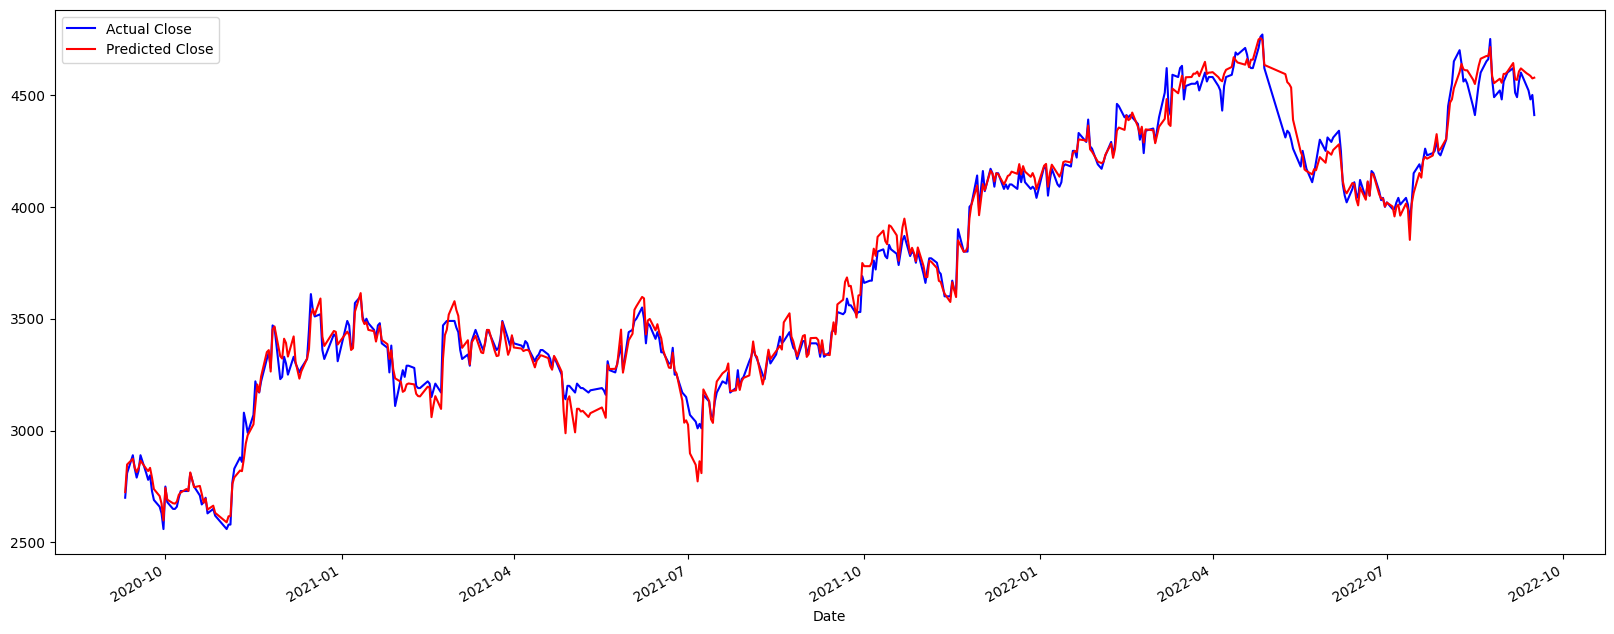

In [29]:
tlkm['Actual Close'].plot(figsize=(20,8), legend=True, color='blue')
tlkm['Predicted Close'].plot(legend=True, color='red', figsize=(20,8))

In [31]:
a = tlkm[(tlkm['Within RMSE Range']=='no') & (tlkm['Diff']<0)]
a.groupby(['year','month']).count()[['Predicted Close', 'Actual Close']].sort_values('Predicted Close', ascending=False).head()

Predicted Close  Actual Close
year month                               
2021 5                   10            10
     2                    9             9
2022 3                    6             6
2021 7                    6             6
2020 11                   4             4

Pada bulan Mei 2021, terdapat 10 observasi dengan harga prediksi Close di bawah harga aktual Close, diikuti oleh bulan Februari 2021, Maret 2022, dan seterusnya. Bisa dilihat juga dari *line plot* di atas bahwa pada bulan Mei 2021 dan Juli 2021, terdapat perbedaan yang signifikan antara Predicted Close dan Actual Close dimana Predicted Close berada di bawah Actual Close.

> Predicted Close > Actual Close

In [33]:
b = tlkm[(tlkm['Within RMSE Range']=='no') & (tlkm['Diff']>=0)]
b.groupby(['year','month']).count()[['Predicted Close', 'Actual Close']].sort_values('Predicted Close', ascending=False).head()

Predicted Close  Actual Close
year month                               
2021 10                  13            13
2020 12                   9             9
2021 9                    8             8
2022 8                    7             7
     9                    6             6

Pada bulan Oktober 2021, terdapat 13 observasi dengan harga prediksi Close di atas harga aktual Close, diikuti oleh bulan Desember 2021, September 2021, dan seterusnya. Bisa dilihat juga dari *line plot* di atas bahwa pada bulan Oktober 2021 dan Juni 2021, terdapat perbedaan yang cukup terlihat antara Predicted Close dan Actual Close dimana Predicted Close berada di atas Actual Close

#### Sudut Pandang Klasifikasi: Naik atau Turun (dari Harga Sebelumnya)
- Naik (Up) => Positive
- Turun (Down) => Negative

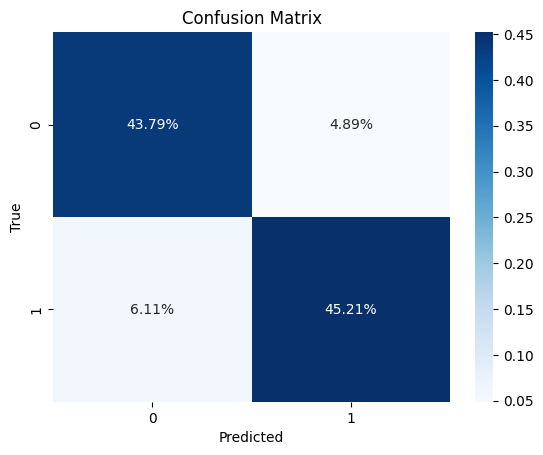

In [8]:
tlkm_tp, tlkm_tn, tlkm_fp, tlkm_fn, tlkm_acc = get_TPTNFPFN(tlkm)

In [9]:
tlkm_acc

0.890020366598778

Model sudah dengan cukup baik memprediksi pergerakan harga saham (naik atau turun) dengan akurasi 89%.

## FREN.JK

In [45]:
fren = pd.read_csv('./error_analysis/fren_err_analysis2.csv', 
                   index_col='Date', parse_dates=True, sep=';')
fren.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,...,Predicted Close,Actual Close,Diff,Within RMSE Range,Actual Return,Predicted Return,TP,TN,FP,FN
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-10,90.00,93.43,103.76,2.16,19.39,31.23,36.63,27.25,47.93,29.09,...,82.58,81.0,1.58,yes,down,down,no,yes,no,no
2020-09-11,88.57,92.07,100.81,3.95,18.44,30.64,36.20,0.00,49.33,29.66,...,80.81,80.0,0.81,yes,down,down,no,yes,no,no
2020-09-14,86.86,90.79,98.29,4.74,41.66,39.17,41.27,21.56,57.30,34.06,...,85.60,87.0,-1.40,yes,up,up,yes,no,no,no
2020-09-15,86.14,90.43,96.24,4.18,38.05,37.75,40.31,31.49,42.05,35.66,...,85.63,85.0,0.63,yes,down,up,no,no,yes,no
2020-09-16,85.29,88.93,94.19,3.59,36.22,37.02,39.82,32.37,25.55,37.73,...,84.58,84.0,0.58,yes,down,down,no,yes,no,no


###  RMSE, MAPE, and R-squared

In [46]:
get_rmse_mape_r2(fren)

,RMSE,MAPE,R-squared
0,3.671208,2.996208,0.963258


In [47]:
get_count_within_rmse_range(fren)

,Predicted Close
Within RMSE Range,
no,124
yes,368


Terdapat 124 observasi memiliki error lebih kecil dari -RMSE dan lebih besar dari RMSE
> di luar range RMSE -3.67 < price < 3.67

#### The Predicted Price: Outside the RMSE Range

> Predicted Close < Actual Close

<AxesSubplot: xlabel='Date'>

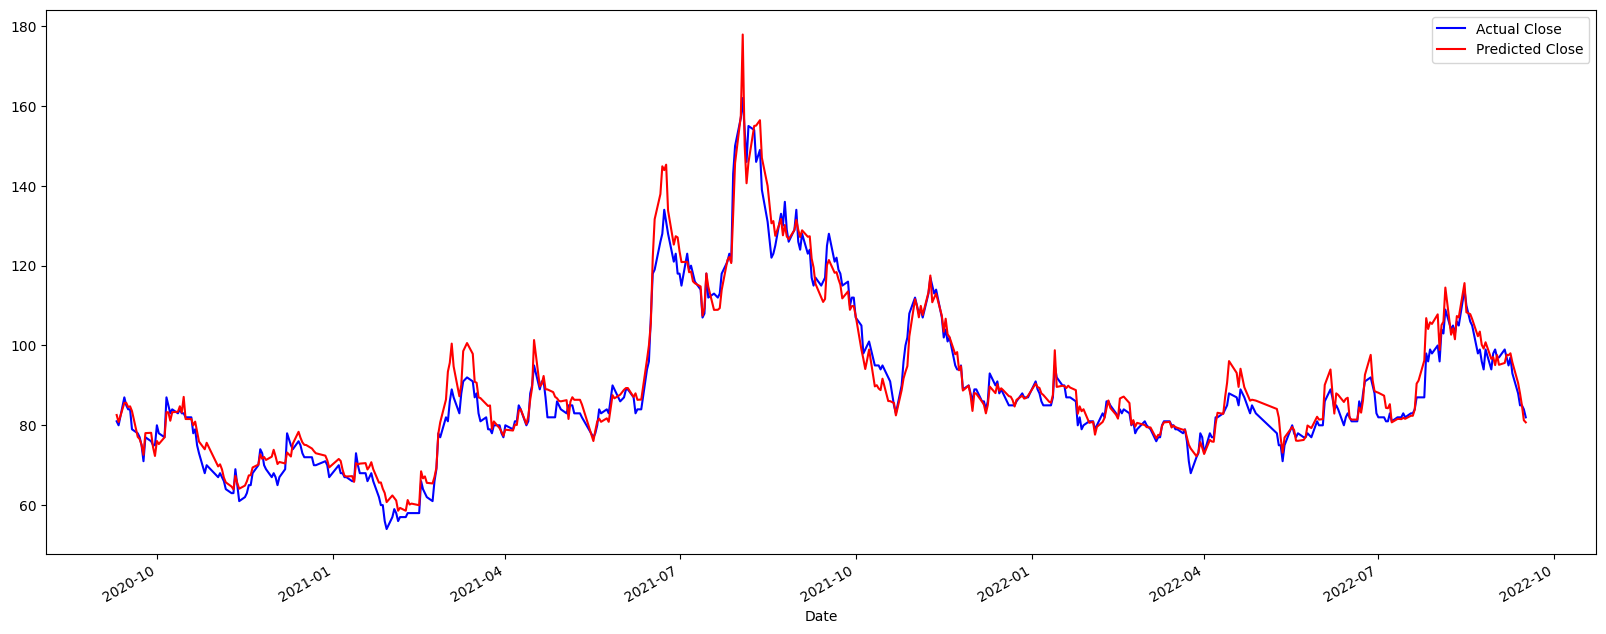

In [48]:
fren['Actual Close'].plot(figsize=(20,8), legend=True, color='blue')
fren['Predicted Close'].plot(legend=True, color='red', figsize=(20,8))

In [49]:
c = fren[(fren['Within RMSE Range']=='no') & (fren['Diff']<0)]
c.groupby(['year','month']).count()[['Predicted Close', 'Actual Close']].sort_values('Predicted Close', ascending=False).head()

Predicted Close  Actual Close
year month                               
2021 10                  12            12
     7                    4             4
     8                    4             4
     9                    4             4
2020 10                   2             2

Pada bulan Oktober 2021, terdapat 12 observasi dengan harga prediksi Close di bawah harga aktual Close, diikuti oleh bulan Juli 2021, Agustus 2022, dan seterusnya. Bisa dilihat juga dari *line plot* di atas bahwa pada bulan Oktober 2021 dan Juli 2021, terdapat perbedaan yang cukup terlihat antara Predicted Close dan Actual Close dimana Predicted Close berada di bawah Actual Close.

> Predicted Close > Actual Close

In [54]:
d = fren[(fren['Within RMSE Range']=='no') & (fren['Diff']>=0)]
d.groupby(['year','month']).count()[['Predicted Close', 'Actual Close']].sort_values('Predicted Close', ascending=False).head()

Predicted Close  Actual Close
year month                               
2021 3                   14            14
     6                   12            12
2022 7                    8             8
2021 8                    7             7
2022 6                    7             7

Pada bulan Maret 2021, terdapat 14 observasi dengan harga prediksi Close di atas harga aktual Close, diikuti oleh bulan Juni 2021, Juli 2022, dan seterusnya. Bisa dilihat juga dari *line plot* di atas bahwa pada bulan Maret 2021, Juni 2021, Juli 2021 dan Agustus 2021, terdapat perbedaan yang signifikan antara Predicted Close dan Actual Close dimana Predicted Close berada di atas Actual Close

#### Sudut Pandang Klasifikasi: Naik atau Turun (dari Harga Sebelumnya)
- Naik (Up) => Positive
- Turun (Down) => Negative

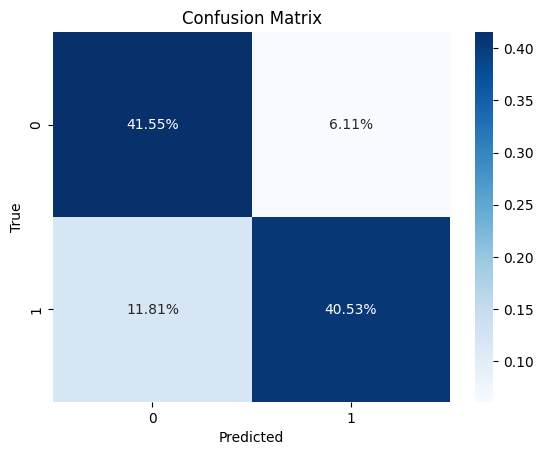

Accuracy: 0.8207739307535642


In [52]:
fren_tp, fren_tn, fren_fp, fren_fn, fren_acc = get_TPTNFPFN(fren)
print(f'Accuracy: {fren_acc}')

Model sudah dengan cukup baik memprediksi pergerakan harga saham (naik atau turun) dengan akurasi 82%.